In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import glob
import random
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
#from sklearn.model_selection import train_test_split



In [1]:
from tensorflow.keras import backend as K
K.clear_session()

In [3]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
for device in devices:
    print(device.name, device.device_type)

/device:CPU:0 CPU


In [4]:
# -------------------------------
# Configuration Parameters
# -------------------------------
# Paths to the datasets (adjust these paths as needed)
LIBRISPEECH_PATH = 'E:\Sumudu CS course stuff\Sem 5\IPCV\Stuffwedo\project_sup_audio\LibriSpeech_devclean_wav'  # Folder structure with WAV files
ESC50_PATH = 'E:\Sumudu CS course stuff\Sem 5\IPCV\Stuffwedo\project_sup_audio\ESC_50_master'              # Folder with ESC-50 WAV files
audio_folder = os.path.join(ESC50_PATH, 'audio')

# Audio parameters
SR = 16000             # Sampling rate
N_FFT = 1024           # FFT window size
HOP_LENGTH = 512       # Hop length
DURATION = 3           # Seconds to sample (trim or pad)

# Noise mixing parameters
#TARGET_SNR = 5        # in dB
TARGET_SNR = random.uniform(-5, 15)

# Training parameters
BATCH_SIZE = 16
EPOCHS = 10

In [5]:
# -------------------------------
# Utility functions
# -------------------------------
def load_audio_files(file_list, sr=SR, duration=DURATION):
    """Load a list of audio files and either trim or pad them to a given duration."""
    audios = []
    for file in file_list:
        y, _ = librosa.load(file, sr=sr)
        # Trim or pad audio to desired duration
        target_len = sr * duration
        if len(y) > target_len:
            y = y[:target_len]
        else:
            y = np.pad(y, (0, max(0, target_len - len(y))), 'constant')
        audios.append(y)
    return audios

def calculate_snr(signal, noise):
    """Calculate SNR (dB) for given clean signal and noise."""
    signal_power = np.mean(signal**2)
    noise_power = np.mean(noise**2)
    return 10 * np.log10(signal_power / noise_power)

def mix_audio(clean, noise, target_snr=TARGET_SNR):
    """Mix a clean signal with a noise signal at a target SNR (in dB)."""
    # Ensure noise and clean have the same length
    if len(noise) < len(clean):
        # loop noise if too short
        noise = np.tile(noise, int(np.ceil(len(clean)/len(noise))))
    noise = noise[:len(clean)]
    
    # Adjust noise power to achieve desired SNR
    signal_power = np.mean(clean ** 2)
    noise_power = np.mean(noise ** 2)
    current_snr = 10 * np.log10(signal_power / noise_power + 1e-8)
    # Calculate scaling factor for noise
    factor = np.sqrt(signal_power / (10**(target_snr/10) * noise_power + 1e-8))
    noisy = clean + noise * factor
    return noisy

def stft_transform(audio):
    """Compute magnitude (and optionally phase) using STFT."""
    stft = librosa.stft(audio, n_fft=N_FFT, hop_length=HOP_LENGTH)
    magnitude = np.abs(stft)
    phase = np.angle(stft)
    return magnitude, phase

def istft_transform(magnitude, phase):
    """Reconstruct audio from magnitude and phase."""
    stft = magnitude * np.exp(1j*phase)
    audio = librosa.istft(stft, hop_length=HOP_LENGTH)
    return audio



In [6]:
# -------------------------------
# 1. Load Datasets
# -------------------------------
# Get lists of files
librispeech_files = glob.glob(os.path.join(LIBRISPEECH_PATH, '**/*.wav'), recursive=True)
esc50_files = glob.glob(os.path.join(audio_folder, '**', '*.wav'), recursive=True)

print(f"Found {len(librispeech_files)} LibriSpeech files and {len(esc50_files)} ESC-50 files.")

# Load audio files into lists (this might take some time)
clean_audios = load_audio_files(librispeech_files, sr=SR, duration=DURATION)
noise_audios = load_audio_files(esc50_files, sr=SR, duration=DURATION)


Found 2703 LibriSpeech files and 2000 ESC-50 files.


In [7]:
# -------------------------------
# 2. Create Noisy Dataset (libriwithnoise)
# -------------------------------
num_noisy_versions = 3  # how many noisy versions per clean
min_snr = -5
max_snr = 15

# For each clean audio, pick a random noise sample and mix
libriwithnoise = []
clean_with_repeats = []
for clean in clean_audios:
    for _ in range(num_noisy_versions):
        noise_sample = random.choice(noise_audios)
        random_snr = random.uniform(min_snr, max_snr)

        noisy = mix_audio(clean, noise_sample, target_snr=random_snr)

        libriwithnoise.append(noisy)
        clean_with_repeats.append(clean)  # repeat clean sample for matching

# Make sure the number of noisy samples matches the number of clean samples
#assert len(libriwithnoise) == len(clean_audios)
assert len(libriwithnoise) == len(clean_with_repeats)


In [20]:
import soundfile as sf

# Output folders
wav_output_dir = 'E:\Sumudu CS course stuff\Sem 5\IPCV\Stuffwedo\project_sup_audio\libriwithnoise_wav'
stft_output_dir = 'E:\Sumudu CS course stuff\Sem 5\IPCV\Stuffwedo\project_sup_audio\libriwithnoise_stft'
os.makedirs(wav_output_dir, exist_ok=True)
os.makedirs(stft_output_dir, exist_ok=True)

# Save WAV and STFT files
for idx, audio in enumerate(libriwithnoise):
    # --- Save WAV ---
    wav_path = os.path.join(wav_output_dir, f'noisy_{idx:04d}.wav')
    sf.write(wav_path, audio, SR)

    # --- Save STFT ---
    stft = librosa.stft(audio, n_fft=N_FFT, hop_length=HOP_LENGTH)
    stft_mag = np.abs(stft)
    stft_path = os.path.join(stft_output_dir, f'noisy_{idx:04d}.npy')
    np.save(stft_path, stft_mag)

In [22]:
# Output folders
wav_output_dir = 'E:\Sumudu CS course stuff\Sem 5\IPCV\Stuffwedo\project_sup_audio\clean_with_repeats_wav'
stft_output_dir = 'E:\Sumudu CS course stuff\Sem 5\IPCV\Stuffwedo\project_sup_audio\clean_with_repeats_stft'
os.makedirs(wav_output_dir, exist_ok=True)
os.makedirs(stft_output_dir, exist_ok=True)

# Save WAV and STFT files
for idx, audio in enumerate(clean_with_repeats):
    # --- Save WAV ---
    wav_path = os.path.join(wav_output_dir, f'clean_repeats_{idx:04d}.wav')
    sf.write(wav_path, audio, SR)

    # --- Save STFT ---
    stft = librosa.stft(audio, n_fft=N_FFT, hop_length=HOP_LENGTH)
    stft_mag = np.abs(stft)
    stft_path = os.path.join(stft_output_dir, f'clean_repeats_{idx:04d}.npy')
    np.save(stft_path, stft_mag)

In [8]:
# -------------------------------
# 3. Split Dataset (80/20)
# -------------------------------
#num_samples = len(clean_audios)
num_samples = len(clean_with_repeats)
indices = list(range(num_samples))
random.shuffle(indices)

train_size = int(0.8 * num_samples)
train_idx = indices[:train_size]
test_idx = indices[train_size:]

#train_clean = [clean_audios[i] for i in train_idx]
#train_noisy = [libriwithnoise[i] for i in train_idx]
#test_clean = [clean_audios[i] for i in test_idx]
#test_noisy = [libriwithnoise[i] for i in test_idx]

train_clean = [clean_with_repeats[i] for i in train_idx]
train_noisy = [libriwithnoise[i] for i in train_idx]
test_clean = [clean_with_repeats[i] for i in test_idx]
test_noisy = [libriwithnoise[i] for i in test_idx]

print(f"Training samples: {len(train_clean)}, Testing samples: {len(test_clean)}")


Training samples: 6487, Testing samples: 1622


In [9]:
# -------------------------------
# 4. STFT Feature Extraction
# -------------------------------
def compute_features(audios):
    """Compute STFT magnitudes for a list of audios."""
    feats = []
    phases = []  # store phase if needed later for reconstruction
    for audio in audios:
        mag, ph = stft_transform(audio)
        feats.append(mag)
        phases.append(ph)
    # Convert to np.array with an extra channel dimension for the CNN
    feats = np.array(feats)[..., np.newaxis]
    return feats, phases

train_clean_feats, train_clean_phases = compute_features(train_clean)
train_noisy_feats, train_noisy_phases = compute_features(train_noisy)
test_clean_feats, test_clean_phases = compute_features(test_clean)
test_noisy_feats, test_noisy_phases = compute_features(test_noisy)

print("Shape of training clean features:", train_clean_feats.shape)
print("Shape of training noisy features:", train_noisy_feats.shape)

Shape of training clean features: (6487, 513, 94, 1)
Shape of training noisy features: (6487, 513, 94, 1)


In [9]:
# -------------------------------
# 5. Build the Denoising Model (UNet-like)
# -------------------------------
from tensorflow.keras import layers, models

def crop_to_match(target, reference):
    target_shape = K.int_shape(target)
    ref_shape = K.int_shape(reference)

    height_diff = (target_shape[1] or 0) - (ref_shape[1] or 0)
    width_diff = (target_shape[2] or 0) - (ref_shape[2] or 0)

    crop_top = max(height_diff // 2, 0)
    crop_bottom = max(height_diff - crop_top, 0)
    crop_left = max(width_diff // 2, 0)
    crop_right = max(width_diff - crop_left, 0)

    return layers.Cropping2D(((crop_top, crop_bottom), (crop_left, crop_right)))(target)

def resize_to_match(source, target):
    source_shape = K.int_shape(source)
    target_shape = K.int_shape(target)

    diff_h = (source_shape[1] or 0) - (target_shape[1] or 0)
    diff_w = (source_shape[2] or 0) - (target_shape[2] or 0)

    crop_top = max(diff_h // 2, 0)
    crop_bottom = max(diff_h - crop_top, 0)
    pad_top = max(-diff_h // 2, 0)
    pad_bottom = max(-diff_h - pad_top, 0)

    crop_left = max(diff_w // 2, 0)
    crop_right = max(diff_w - crop_left, 0)
    pad_left = max(-diff_w // 2, 0)
    pad_right = max(-diff_w - pad_left, 0)

    x = source
    if crop_top or crop_bottom or crop_left or crop_right:
        x = layers.Cropping2D(((crop_top, crop_bottom), (crop_left, crop_right)))(x)
    if pad_top or pad_bottom or pad_left or pad_right:
        x = layers.ZeroPadding2D(((pad_top, pad_bottom), (pad_left, pad_right)))(x)

    return x


def build_denoiser(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoding path
    conv1 = layers.Conv2D(16, (3, 3), padding='same')(inputs)
    act1 = layers.LeakyReLU()(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(act1)

    conv2 = layers.Conv2D(32, (3, 3), padding='same')(pool1)
    act2 = layers.LeakyReLU()(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(act2)

    conv3 = layers.Conv2D(64, (3, 3), padding='same')(pool2)
    act3 = layers.LeakyReLU()(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(act3)

    # Additional encoding layer (deeper level)
    conv4 = layers.Conv2D(128, (3, 3), padding='same')(pool3)
    act4 = layers.LeakyReLU()(conv4)

    
    # First decoder block: upsample from deepest features
    up3 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(act4)
    up_act3 = layers.LeakyReLU()(up3)
    up_act3 = resize_to_match(up_act3, act3)
    concat3 = layers.concatenate([up_act3, act3])

    # Decoding path
    up2 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(act3)
    up_act2 = layers.LeakyReLU()(up2)
    up_act2 = resize_to_match(up_act2, act2)
    concat2 = layers.concatenate([up_act2, act2])
    
    up1 = layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(concat2)
    up_act1 = layers.LeakyReLU()(up1)
    up_act1 = resize_to_match(up_act1, act1)
    concat1 = layers.concatenate([up_act1, act1])
    
    
    # Final output layer
    #conv_final = layers.Conv2D(1, (3, 3), activation='tanh', padding='same')(concat1)
    conv_final = layers.Conv2D(1, (3, 3), activation='linear', padding='same')(concat1)
    
    model = models.Model(inputs, conv_final)
    return model


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

input_shape = train_noisy_feats.shape[1:]  # (freq_bins, time_frames, 1)
model = build_denoiser(input_shape)
model.compile(optimizer = optimizers.Adam(learning_rate=lr_schedule), loss='mse')
#model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='mse')
#model.compile(optimizer=optimizers.Adam(1e-3), loss='mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 513, 94, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 513, 94, 16)  160         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 513, 94, 16)  0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 256, 47, 16)  0           ['leaky_re_lu[0][0]']        

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    '../models/checkpoints/denoiser_epoch322_{epoch:02d}.h5',  # or .keras
    save_freq='epoch',          # save after every epoch
    save_weights_only=False,    # set True if you want to save weights only
    monitor='val_loss',         # optional: can monitor val_loss to save best
    save_best_only=False        # or True to keep only best performing
)


In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_callback = ReduceLROnPlateau(
    monitor='val_loss',   # Watch validation loss
    factor=0.5,           # Halve the learning rate
    patience=3,           # Wait 2 epochs with no improvement
    min_lr=1e-6,          # Don’t go below this
    verbose=1             # Optional: prints when LR changes
)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('../models/checkpoints/denoiser_epoch_07.h5')  # Example: load epoch 7


In [13]:
# -------------------------------
# 6. Train the Model
# -------------------------------
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_cb = ModelCheckpoint("../models/best_model32.h5", save_best_only=True)
earlystop_cb = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Train using the noisy features as inputs and clean features as targets.
history = model.fit(
    train_noisy_feats, train_clean_feats,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=[checkpoint_cb, earlystop_cb, lr_callback]
)




Epoch 1/10
365/365 [==============================] - ETA: 0s - loss: 0.2338

TypeError: unsupported operand type(s) for *: 'ExponentialDecay' and 'int'

In [16]:
# Train using the noisy features as inputs and clean features as targets.
class LRSchedulerLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer._decayed_lr(tf.float32).numpy()
        print(f"\nEpoch {epoch+1}: Learning rate is {lr:.6f}")

lr_logger = LRSchedulerLogger()

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_cb = ModelCheckpoint("../models/best_model322.h5", save_best_only=True)
earlystop_cb = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    train_noisy_feats, train_clean_feats,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    callbacks=[checkpoint_cb, earlystop_cb, lr_logger]
)

Epoch 1/10
365/365 [==============================] - ETA: 0s - loss: 0.2365
Epoch 1: Learning rate is 0.001000
365/365 [==============================] - 233s 637ms/step - loss: 0.2365 - val_loss: 0.2460
Epoch 2/10
365/365 [==============================] - ETA: 0s - loss: 0.2258
Epoch 2: Learning rate is 0.001000
365/365 [==============================] - 229s 627ms/step - loss: 0.2258 - val_loss: 0.2244
Epoch 3/10
365/365 [==============================] - ETA: 0s - loss: 0.2213
Epoch 3: Learning rate is 0.001000
365/365 [==============================] - 228s 624ms/step - loss: 0.2213 - val_loss: 0.2295
Epoch 4/10
365/365 [==============================] - ETA: 0s - loss: 0.2176
Epoch 4: Learning rate is 0.001000
365/365 [==============================] - 230s 631ms/step - loss: 0.2176 - val_loss: 0.2153
Epoch 5/10
365/365 [==============================] - ETA: 0s - loss: 0.2184
Epoch 5: Learning rate is 0.001000
365/365 [==============================] - 239s 655ms/step - loss: 0

In [17]:
# Save the trained model
model.save("../models/denoising_unet_modeltrail322.h5")


In [18]:
model.save_weights("../models/denoising_unet_weights322.h5")


In [ ]:
#If loading the model later
from tensorflow.keras.models import load_model
model = load_model("denoising_unet_model.h5")


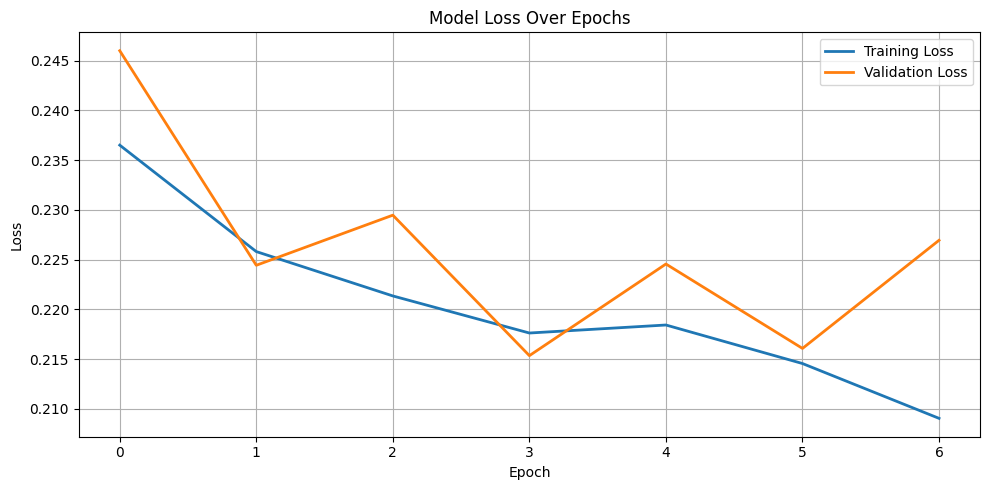

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 185ms/step


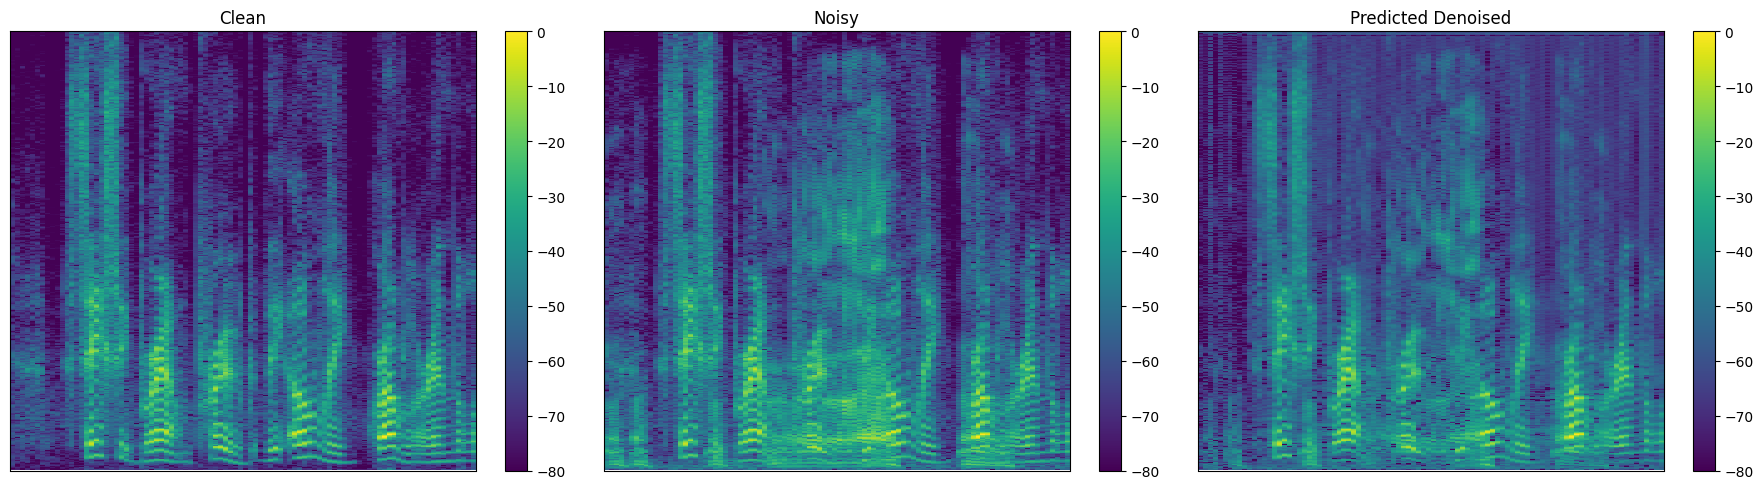

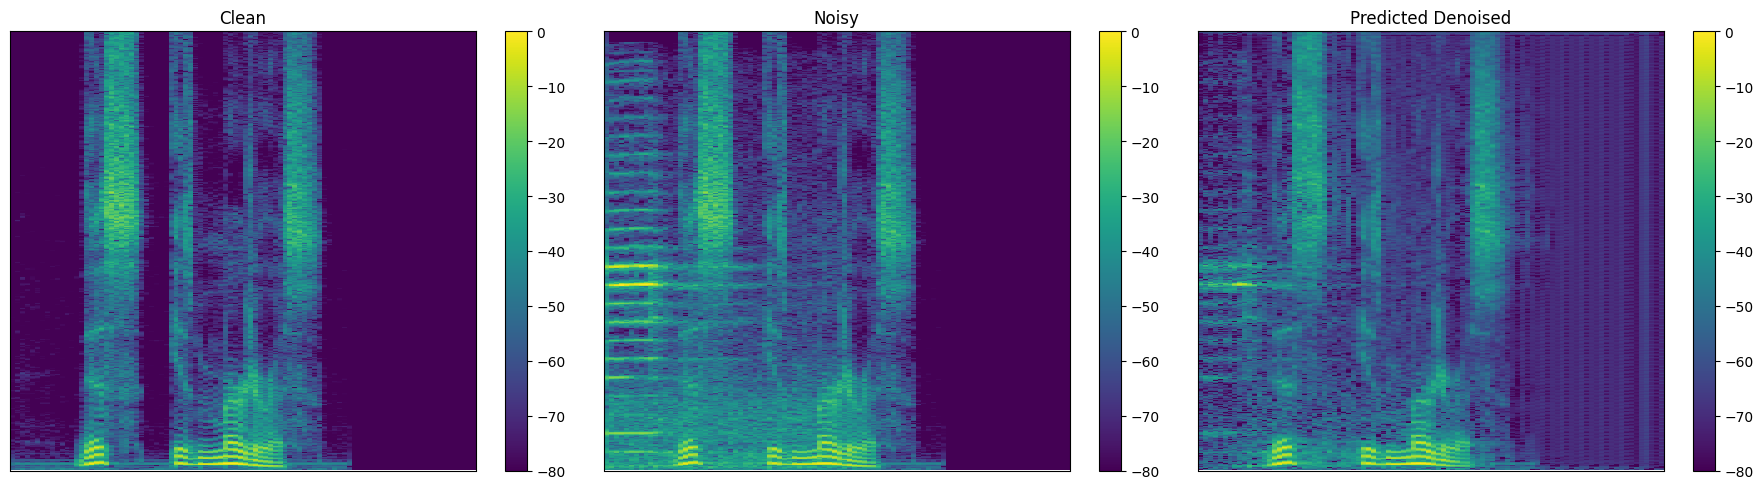

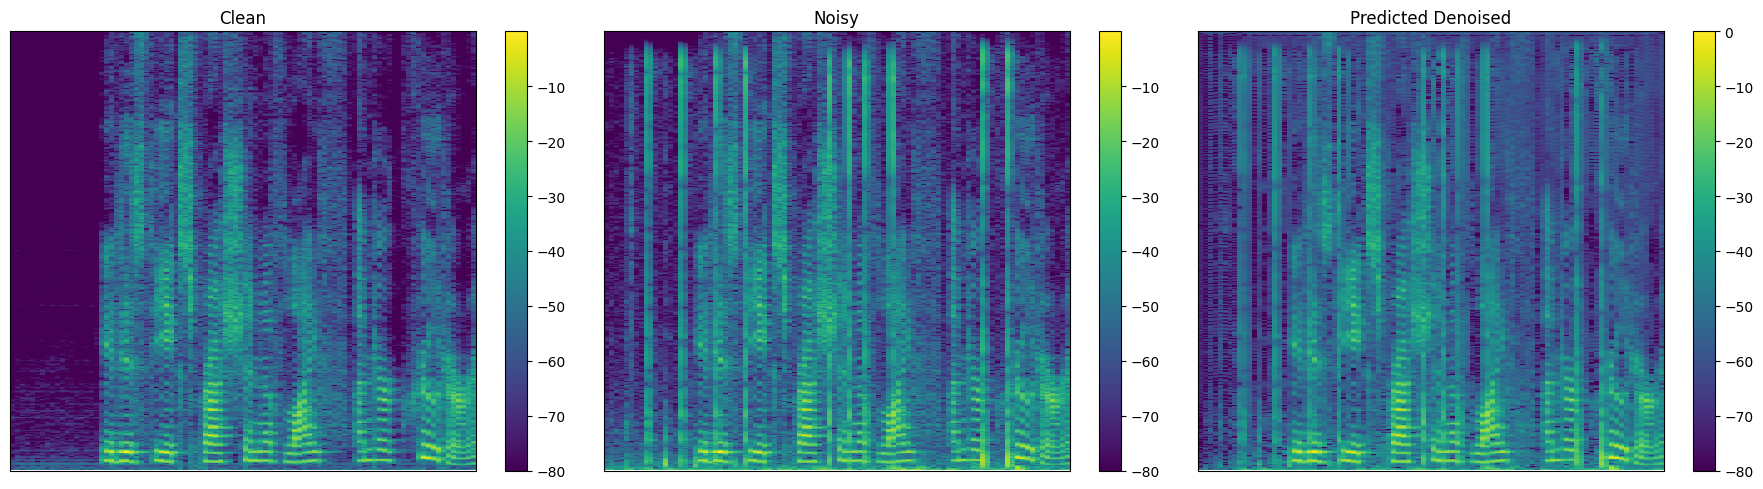

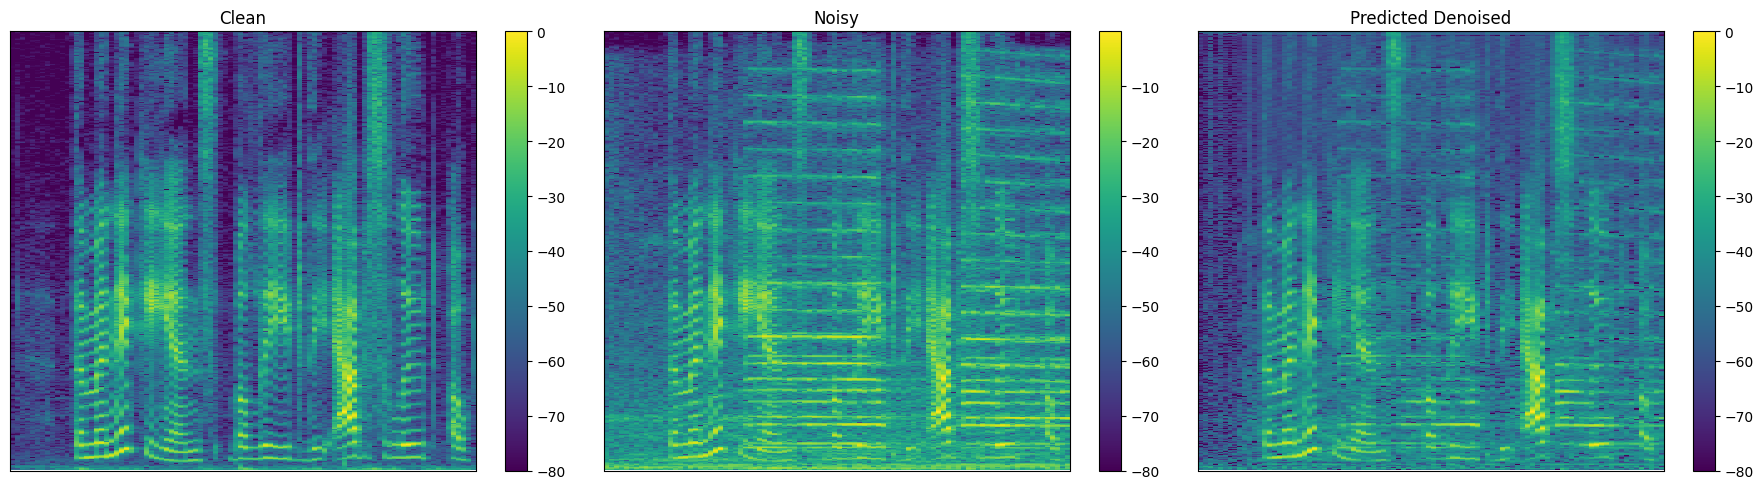

In [20]:
# -------------------------------
# 7. Testing and Visualization
# -------------------------------
# Pick 3 random samples from the testing set
num_test_examples = 4
sample_indices = random.sample(range(len(test_noisy_feats)), num_test_examples)
predicted_feats = model.predict(test_noisy_feats[sample_indices])

# Plot the STFT magnitude spectrograms of clean, noisy, and predicted for each sample.
for idx in sample_indices:
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    # Compute dB-scaled spectrograms for visualization
    clean_db = librosa.amplitude_to_db(test_clean_feats[idx, :, :, 0], ref=np.max)
    noisy_db = librosa.amplitude_to_db(test_noisy_feats[idx, :, :, 0], ref=np.max)
    pred_db = librosa.amplitude_to_db(predicted_feats[sample_indices.index(idx), :, :, 0], ref=np.max)
    
    img1 = librosa.display.specshow(clean_db, sr=SR, hop_length=HOP_LENGTH, ax=ax[0], cmap="viridis")
    ax[0].set_title("Clean")
    fig.colorbar(img1, ax=ax[0])
    
    img2 = librosa.display.specshow(noisy_db, sr=SR, hop_length=HOP_LENGTH, ax=ax[1], cmap="viridis")
    ax[1].set_title("Noisy")
    fig.colorbar(img2, ax=ax[1])
    
    img3 = librosa.display.specshow(pred_db, sr=SR, hop_length=HOP_LENGTH, ax=ax[2], cmap="viridis")
    ax[2].set_title("Predicted Denoised")
    fig.colorbar(img3, ax=ax[2])
    
    plt.tight_layout()
    plt.show()


In [32]:
def plot_waveforms(clean_audio, noisy_audio, denoised_audio, sr=16000):
    plt.figure(figsize=(15, 6))
    plt.subplot(3, 1, 1)
    plt.plot(clean_audio)
    plt.title('Clean Audio')

    plt.subplot(3, 1, 2)
    plt.plot(noisy_audio)
    plt.title('Noisy Audio')

    plt.subplot(3, 1, 3)
    plt.plot(denoised_audio)
    plt.title('Denoised Audio')
    plt.tight_layout()
    plt.show()



🎧 Sample 1
✅ Clean


❌ Noisy


✨ Predicted (Denoised)


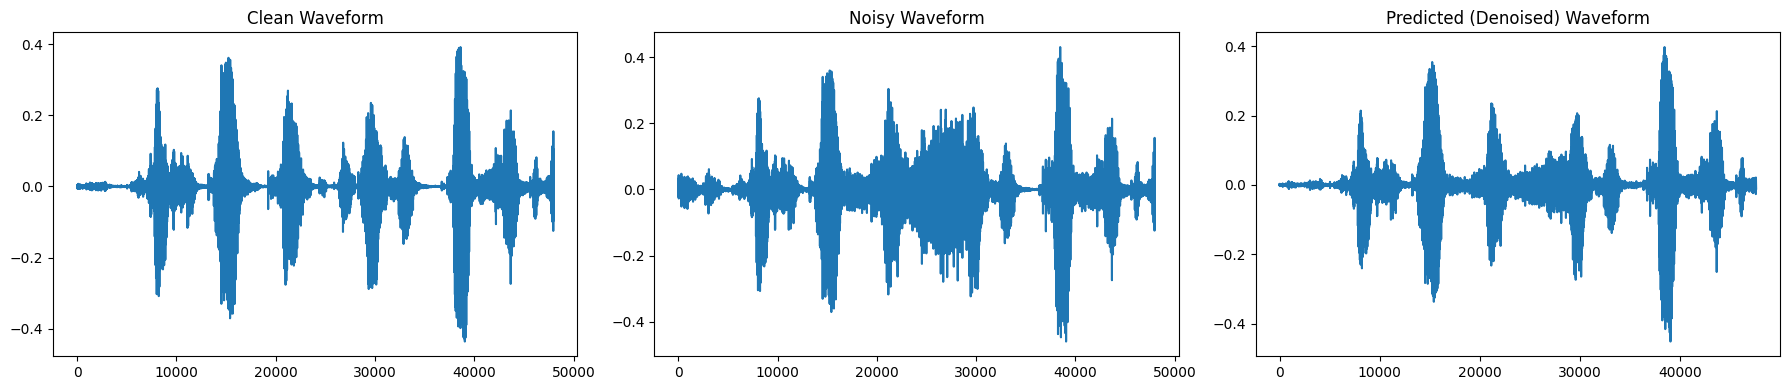


🎧 Sample 2
✅ Clean


❌ Noisy


✨ Predicted (Denoised)


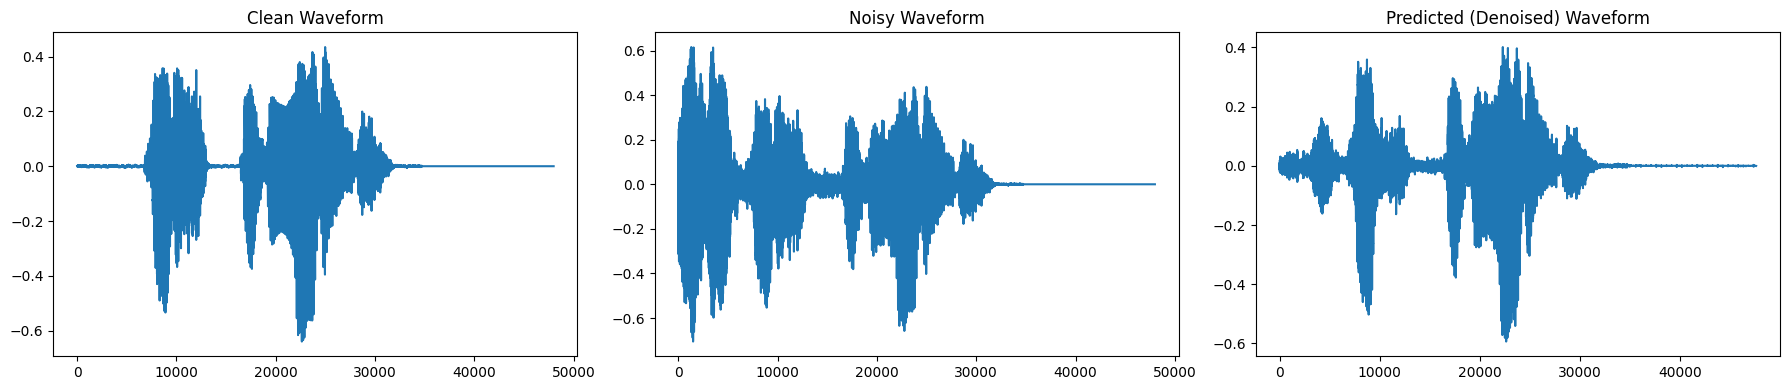


🎧 Sample 3
✅ Clean


❌ Noisy


✨ Predicted (Denoised)


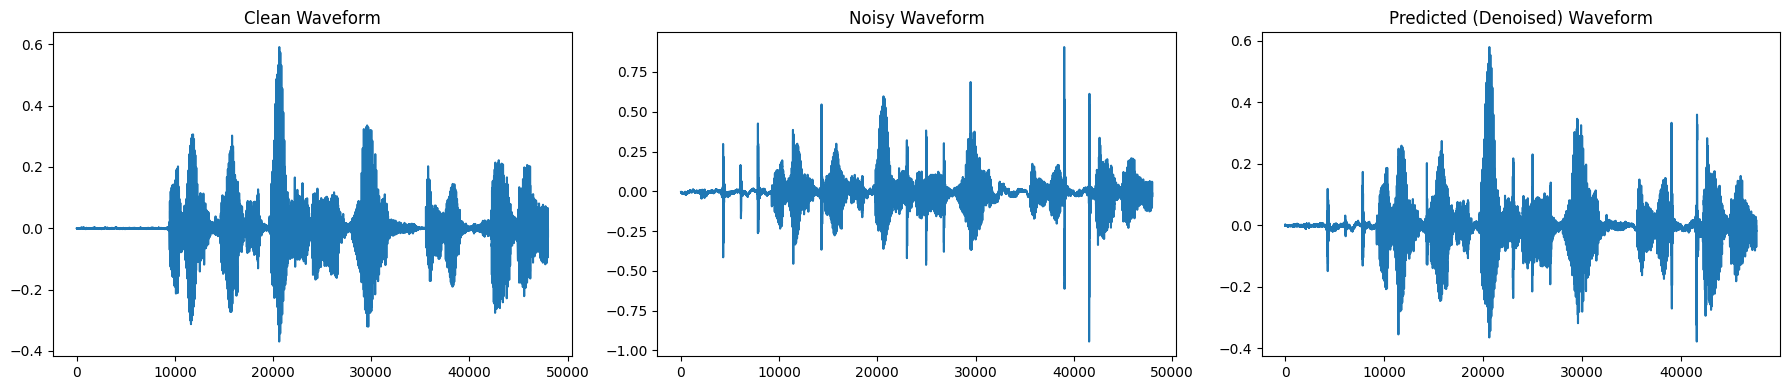


🎧 Sample 4
✅ Clean


❌ Noisy


✨ Predicted (Denoised)


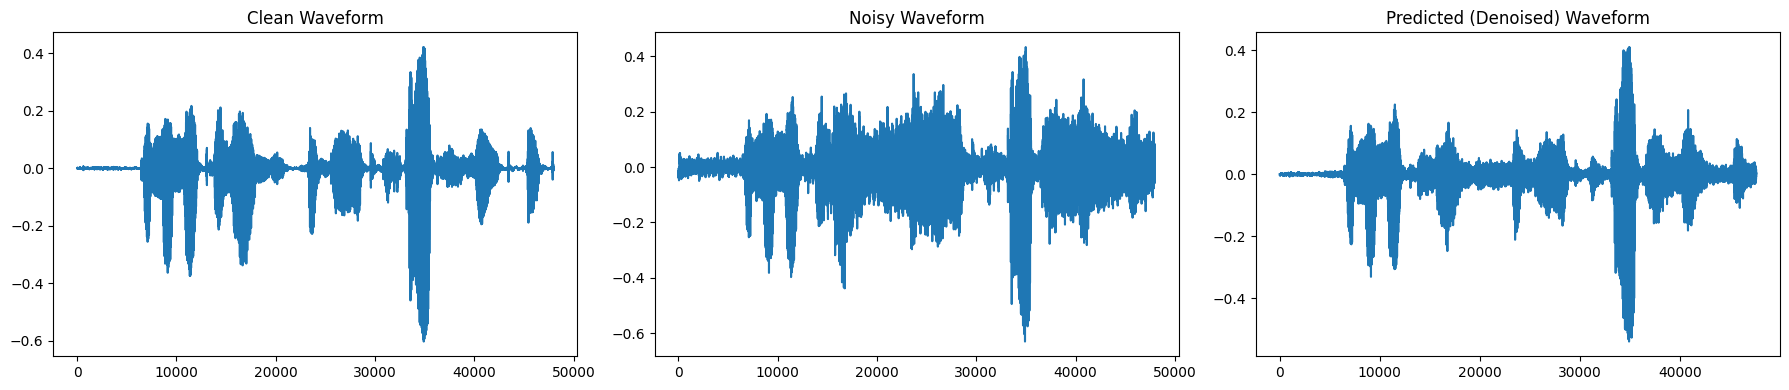

In [23]:
import IPython.display as ipd

def istft_from_magnitude(mag, phase_reference):
    """Combine magnitude with phase and invert STFT"""
    stft_complex = mag * np.exp(1j * np.angle(phase_reference))
    return librosa.istft(stft_complex, hop_length=HOP_LENGTH)

for i, idx in enumerate(sample_indices):
    print(f"\n🎧 Sample {i+1}")

    # Get original STFTs
    noisy_feat = test_noisy_feats[idx].squeeze()
    clean_feat = test_clean_feats[idx].squeeze()
    pred_feat = predicted_feats[i].squeeze()

    # Recover original complex STFTs to get phase
    noisy_audio = test_noisy[idx]
    clean_audio = test_clean[idx]

    stft_noisy = librosa.stft(noisy_audio, n_fft=N_FFT, hop_length=HOP_LENGTH)
    stft_clean = librosa.stft(clean_audio, n_fft=N_FFT, hop_length=HOP_LENGTH)

    # Invert STFT using phase from noisy signal
    pred_audio = istft_from_magnitude(pred_feat, stft_noisy)

    # Listen
    print("✅ Clean")
    display(ipd.Audio(clean_audio, rate=SR))

    print("❌ Noisy")
    display(ipd.Audio(noisy_audio, rate=SR))

    print("✨ Predicted (Denoised)")
    display(ipd.Audio(pred_audio, rate=SR))


    fig, ax = plt.subplots(1, 3, figsize=(18, 4))

    ax[0].plot(clean_audio)
    ax[0].set_title("Clean Waveform")

    ax[1].plot(noisy_audio)
    ax[1].set_title("Noisy Waveform")

    ax[2].plot(pred_audio)
    ax[2].set_title("Predicted (Denoised) Waveform")

    plt.tight_layout()
    plt.show()


In [22]:
# 📊 Plot waveforms
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))

    ax[0].plot(clean_audio)
    ax[0].set_title("Clean Waveform")

    ax[1].plot(noisy_audio)
    ax[1].set_title("Noisy Waveform")

    ax[2].plot(pred_audio)
    ax[2].set_title("Predicted (Denoised) Waveform")

    plt.tight_layout()
    plt.show()

IndentationError: unexpected indent (3749323691.py, line 2)

In [14]:
from tensorflow.keras.models import load_model
model = load_model("../models/denoising_unet_modeltrail31.h5")

In [13]:
print(type(train_noisy_feats), train_noisy_feats.shape)
print(type(train_clean_feats), train_clean_feats.shape)


<class 'numpy.ndarray'> (6487, 513, 94, 1)
<class 'numpy.ndarray'> (6487, 513, 94, 1)
